In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('datasets/Credit.csv')
df.head()

,Credit,RevolvingUtiOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NoOfDependents,NoRealEstateLoansOrLines,NoOfOpenCreditLinesAndLoans,NoofTime30_59DaysPastDue,NoOfTime60_89DaysPastDue,NorOfTimes90DaysLate
0,1,0.766127,45,0.802982,9120,2,6,13,2,0,0
1,0,0.957151,40,0.121876,2600,1,0,4,0,0,0
2,0,0.658180,38,0.085113,3042,0,0,2,1,0,1
3,0,0.233810,30,0.036050,3300,0,0,5,0,0,0
4,0,0.907239,49,0.024926,63588,0,1,7,1,0,0


In [3]:
x=df.iloc[:,1:]
y=df.Credit

In [4]:
from sklearn.model_selection import train_test_split

In [6]:
#for classification problems we stratify y to keep the same proportion of classes in both the train and test sets
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,random_state=0)

In [7]:
# standardize the data
from sklearn.preprocessing import StandardScaler

In [8]:
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)

In [9]:
n_features = x_train_std.shape[1]

In [12]:
# build the network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.regularizers import L1, L2
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

In [17]:
model = Sequential()
model.add(Input(shape=(n_features)))
model.add(Dense(15,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='sigmoid')) # binary classification problem

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Precision(),Recall()])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 15)                165       
                                                                 
 dense_10 (Dense)            (None, 8)                 128       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 302
Trainable params: 302
Non-trainable params: 0
_________________________________________________________________


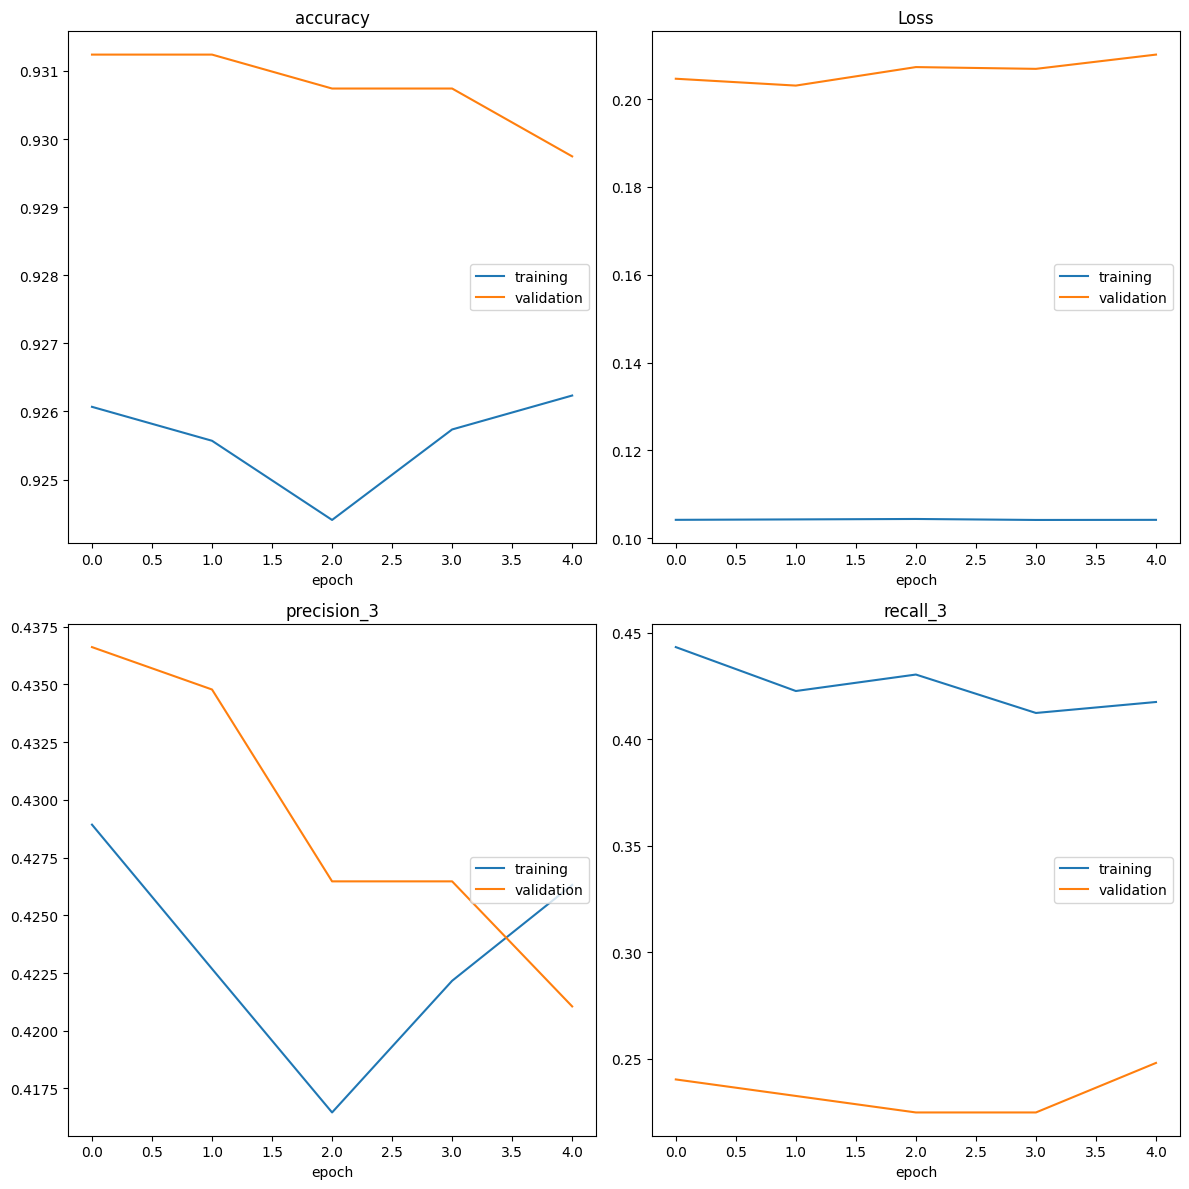

accuracy
	training         	 (min:    0.924, max:    0.926, cur:    0.926)
	validation       	 (min:    0.930, max:    0.931, cur:    0.930)
Loss
	training         	 (min:    0.104, max:    0.104, cur:    0.104)
	validation       	 (min:    0.203, max:    0.210, cur:    0.210)
precision_3
	training         	 (min:    0.416, max:    0.429, cur:    0.426)
	validation       	 (min:    0.421, max:    0.437, cur:    0.421)
recall_3
	training         	 (min:    0.412, max:    0.443, cur:    0.418)
	validation       	 (min:    0.225, max:    0.248, cur:    0.248)
189/189 [==============================] - 1s 6ms/step - loss: 0.1042 - accuracy: 0.9262 - precision_3: 0.4263 - recall_3: 0.4175 - val_loss: 0.2101 - val_accuracy: 0.9297 - val_precision_3: 0.4211 - val_recall_3: 0.2481


In [21]:
# Create a parameter that will stop training if a given condition exists
es = EarlyStopping(
    monitor='val_loss',  # parameter to monitor
    patience=3  # consecutive epochs needed to create stopping condition
)

model.fit(
    x_train_std, 
    y_train,
    epochs=30,
    batch_size=32,
    validation_data=(x_test_std,y_test),
    callbacks=[PlotLossesKerasTF(),es],  # add es as a callback function to the model
    class_weight={0:0.3,1:0.8} # imbalanced data -- want to predict class 1 with more precision
)

# if validation loss goes up 3 epochs in a row the model will stop training

# Hyperparameter Tuning
## Random Search

In [22]:
import keras_tuner

In [25]:
# define a function that we can continuously call to try different hyper parameters
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(n_features)))
    
    # parameterize number of nodes in the first hidden layer
    model.add(Dense(hp.Choice('units',[12,15,18,20,32,11,10]),activation='relu'))
    
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',Precision(),Recall()])
    return model

In [26]:
tuner = keras_tuner.RandomSearch(build_model,objective='val_loss',max_trials=5)

In [ ]:
tuner.search(x_train_std,y_train,epochs=30,validation_data=(x_test_std,y_test))

Trial 2 Complete [00h 00m 12s]
val_loss: 0.1922467201948166

Best val_loss So Far: 0.1922467201948166
Total elapsed time: 00h 00m 24s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
11                |18                |units

Epoch 1/30
189/189 [==============================] - 1s 3ms/step - loss: 0.6418 - accuracy: 0.7309 - precision: 0.0953 - recall: 0.3737 - val_loss: 0.4535 - val_accuracy: 0.9258 - val_precision: 0.1875 - val_recall: 0.0465
Epoch 2/30
189/189 [==============================] - 0s 2ms/step - loss: 0.3598 - accuracy: 0.9257 - precision: 0.0597 - recall: 0.0103 - val_loss: 0.2999 - val_accuracy: 0.9283 - val_precision: 0.1739 - val_recall: 0.0310
Epoch 3/30
189/189 [==============================] - 0s 2ms/step - loss: 0.2654 - accuracy: 0.9296 - precision: 0.0909 - recall: 0.0103 - val_loss: 0.2566 - val_accuracy: 0.9322 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
189/189 [==============================] - 0s 2ms/